In [17]:
# STEP 1: Parameter Setup
class Args:
    batch_size = 4
    image_size = 224
    learning_rate = 0.0001
    max_epochs = 15
    num_workers = 4
    validation_interval = 2
    loss_log_filename = "loss_log.csv"
    loss_plot_filename = "loss_plot.png"
    checkpoint_dir = "checkpoints"
    checkpoint_filename = "best_vit_colorization"
    plot_figsize = (10, 7)
    plot_dpi = 300
    dropout_rate = 0.1
    cache_dir = "./cache"
    folder_path = "."   # ✅ THIS IS CORRECT FOR YOUR STRUCTURE

args = Args()


In [2]:
# STEP 2: Imports
!pip install torch torchvision torchaudio \
    transformers \
    lightning \
    scikit-image \
    matplotlib \
    pandas \
    opencv-python


import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from skimage.color import rgb2lab
from transformers import ViTFeatureExtractor, ViTModel
import torch.nn as nn
import torch.nn.functional as F
from lightning import LightningModule, Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, Callback
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from torchvision import models
from torchvision.models import VGG19_Weights


2025-03-16 14:32:11.714832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# STEP 3: Dataset Class
class ColorizationDataset(Dataset):
    def __init__(self, image_paths, transform=None, cache_dir=None):
        self.image_paths = image_paths
        self.transform = transform
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(
            "google/vit-base-patch16-224-in21k", cache_dir=cache_dir, do_rescale=False)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        img_np = np.array(img.permute(1, 2, 0))
        img_lab = rgb2lab(img_np).astype("float32")
        img_l = img_lab[:, :, 0] / 100.0
        img_ab = img_lab[:, :, 1:] / 128.0
        img_l = torch.tensor(img_l).unsqueeze(0)
        img_ab = torch.tensor(img_ab).permute(2, 0, 1)
        vit_inputs = self.feature_extractor(img, return_tensors="pt")
        pixel_values = vit_inputs["pixel_values"].squeeze(0)
        return img_l, img_ab, pixel_values


In [4]:
# STEP 4: Perceptual Loss using VGG19
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.vgg = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features[:16]
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.vgg.eval()
        self.l1_loss = nn.L1Loss()

    def forward(self, pred, target):
        pred_features = self.vgg(pred)
        target_features = self.vgg(target)
        return self.l1_loss(pred_features, target_features)


In [5]:
# STEP 5: ViT + CNN Model with Perceptual Loss
class ViTColorizationModel(LightningModule):
    def __init__(self, model_id="google/vit-base-patch16-224-in21k", dropout_rate=0.1, cache_dir=None, learning_rate=0.0001):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.vit = ViTModel.from_pretrained(model_id, cache_dir=cache_dir)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(768, 512, 3, 2, 1, output_padding=1),
            nn.ReLU(), nn.Dropout(dropout_rate),
            nn.ConvTranspose2d(512, 256, 3, 2, 1, output_padding=1),
            nn.ReLU(), nn.Dropout(dropout_rate),
            nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1),
            nn.ReLU(), nn.Dropout(dropout_rate),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1),
            nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Conv2d(64, 2, 3, 1, 1),
            nn.Tanh()
        )
        self.perceptual_loss = PerceptualLoss()

    def forward(self, pixel_values):
        features = self.vit(pixel_values).last_hidden_state[:, 1:, :]
        B, N, D = features.shape
        H = W = int(N ** 0.5)
        features = features.permute(0, 2, 1).reshape(B, D, H, W)
        return self.decoder(features)

    def training_step(self, batch, batch_idx):
        img_l, img_ab, pixel_values = [x.to(self.device) for x in batch]
        pred_ab = self(pixel_values)
        mse = F.mse_loss(pred_ab, img_ab)
        pred_rgb = torch.cat([img_l, pred_ab], dim=1)
        target_rgb = torch.cat([img_l, img_ab], dim=1)
        perceptual = self.perceptual_loss(pred_rgb, target_rgb)
        loss = mse + 0.1 * perceptual
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        img_l, img_ab, pixel_values = [x.to(self.device) for x in batch]
        pred_ab = self(pixel_values)
        mse = F.mse_loss(pred_ab, img_ab)
        pred_rgb = torch.cat([img_l, pred_ab], dim=1)
        target_rgb = torch.cat([img_l, img_ab], dim=1)
        perceptual = self.perceptual_loss(pred_rgb, target_rgb)
        loss = mse + 0.1 * perceptual
        self.log("val_loss", loss.cpu(), prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        img_l, img_ab, pixel_values = [x.to(self.device) for x in batch]
        pred_ab = self(pixel_values)
        mse = F.mse_loss(pred_ab, img_ab)
        pred_rgb = torch.cat([img_l, pred_ab], dim=1)
        target_rgb = torch.cat([img_l, img_ab], dim=1)
        perceptual = self.perceptual_loss(pred_rgb, target_rgb)
        loss = mse + 0.1 * perceptual
        psnr = 10 * torch.log10(1.0 / loss)
        self.log("test_loss", loss, prog_bar=True)
        self.log("psnr", psnr, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)


In [6]:
# STEP 6: LossPlotCallback (CSV + Plotting)
class LossPlotCallback(LearningRateMonitor):
    def __init__(self, cache_dir, loss_log_filename, loss_plot_filename, plot_figsize, plot_dpi):
        super().__init__()
        self.cache_dir = cache_dir
        self.loss_log_filename = loss_log_filename
        self.loss_plot_filename = loss_plot_filename
        self.plot_figsize = plot_figsize
        self.plot_dpi = plot_dpi

    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        train_loss = metrics.get("train_loss", None)
        val_loss = metrics.get("val_loss", None)

        log_path = os.path.join(self.cache_dir, self.loss_log_filename)
        if os.path.exists(log_path):
            df = pd.read_csv(log_path)
        else:
            df = pd.DataFrame(columns=["epoch", "train_loss", "val_loss"])

        new_data = pd.DataFrame({
            "epoch": [trainer.current_epoch + 1],
            "train_loss": [train_loss.cpu().numpy() if train_loss is not None else None],
            "val_loss": [val_loss.cpu().numpy() if val_loss is not None else None]
        })

        df = pd.concat([df, new_data], ignore_index=True)
        df.to_csv(log_path, index=False)

        # Plot loss curve
        plt.figure(figsize=self.plot_figsize)
        plt.plot(df["epoch"], df["train_loss"], label="Train Loss", marker="o")
        plt.plot(df["epoch"], df["val_loss"], label="Val Loss", marker="o", linestyle="--")
        plt.title("Training vs Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plot_path = os.path.join(self.cache_dir, self.loss_plot_filename)
        plt.savefig(plot_path, dpi=self.plot_dpi)
        plt.close()


In [7]:
# STEP 7a: Text Logger
class TextLogger:
    def __init__(self, log_dir):
        self.log_file = os.path.join(log_dir, "training_log.txt")
        with open(self.log_file, "w") as f:
            f.write("Epoch | Train Loss | Val Loss | Test Loss | PSNR\n")
            f.write("-" * 60 + "\n")

    def log_epoch(self, epoch, train_loss, val_loss):
        train_loss = f"{train_loss:.6f}" if train_loss is not None else "N/A"
        val_loss = f"{val_loss:.6f}" if val_loss is not None else "N/A"
        with open(self.log_file, "a") as f:
            f.write(f"{epoch:>5} | {train_loss:>10} | {val_loss:>10} | {'-'*8} | {'-'*5}\n")

    def log_test(self, test_loss, psnr):
        test_loss = f"{test_loss:.6f}" if test_loss is not None else "N/A"
        psnr = f"{psnr:.2f} dB" if psnr is not None else "N/A"
        with open(self.log_file, "a") as f:
            f.write(f"{'-'*5} | {'-'*10} | {'-'*10} | {test_loss:>8} | {psnr:>5}\n")
            f.write("=" * 60 + "\n")

# STEP 7b: Loss Logging Callback
class LossLoggingCallback(Callback):
    def __init__(self, text_logger):
        super().__init__()
        self.text_logger = text_logger

    def on_train_epoch_end(self, trainer, pl_module):
        epoch = trainer.current_epoch + 1
        train_loss = trainer.callback_metrics.get("train_loss", None)
        val_loss = trainer.callback_metrics.get("val_loss", None)
        self.text_logger.log_epoch(epoch, train_loss, val_loss)

    def on_test_end(self, trainer, pl_module):
        test_loss = trainer.callback_metrics.get("test_loss", None)
        psnr = trainer.callback_metrics.get("psnr", None)
        self.text_logger.log_test(test_loss, psnr)


In [9]:
# STEP 8: Dataset Loading + Training + Auto Checkpoint Save (with file filter fix)

# Build cache directory
CACHE_DIR = os.path.join(args.cache_dir, f"run_bs{args.batch_size}_lr{args.learning_rate}")
os.makedirs(CACHE_DIR, exist_ok=True)

# Define image transform
transform = transforms.Compose([
    transforms.Resize((args.image_size, args.image_size)),
    transforms.ToTensor()
])

# Filter only valid image files (avoid .ipynb, .txt, etc.)
def filter_image_files(file_list):
    valid_exts = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
    return [f for f in file_list if os.path.splitext(f)[1].lower() in valid_exts]

# Load dataset files
train_files = filter_image_files(sorted(glob(os.path.join(args.folder_path, "train", "*.*"))))
val_files = filter_image_files(sorted(glob(os.path.join(args.folder_path, "val", "*.*"))))
test_files = filter_image_files(sorted(glob(os.path.join(args.folder_path, "test", "*.*"))))

print(f"Train files: {len(train_files)} | Val files: {len(val_files)} | Test files: {len(test_files)}")

# Create dataset objects
train_dataset = ColorizationDataset(train_files, transform=transform, cache_dir=CACHE_DIR)
val_dataset = ColorizationDataset(val_files, transform=transform, cache_dir=CACHE_DIR)
test_dataset = ColorizationDataset(test_files, transform=transform, cache_dir=CACHE_DIR)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

# Initialize model
model = ViTColorizationModel(dropout_rate=args.dropout_rate, cache_dir=CACHE_DIR, learning_rate=args.learning_rate)

# Create checkpoint directory
os.makedirs(os.path.join(CACHE_DIR, args.checkpoint_dir), exist_ok=True)

# Checkpoint callback to save best model
checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(CACHE_DIR, args.checkpoint_dir),
    filename=args.checkpoint_filename,
    monitor="val_loss",
    save_top_k=1,
    save_weights_only=False,
    mode="min",
    verbose=True
)

# Loss plot callback
loss_plot_callback = LossPlotCallback(
    cache_dir=CACHE_DIR,
    loss_log_filename=args.loss_log_filename,
    loss_plot_filename=args.loss_plot_filename,
    plot_figsize=args.plot_figsize,
    plot_dpi=args.plot_dpi
)

# Text logger callback
text_logger = TextLogger(CACHE_DIR)
loss_logging_callback = LossLoggingCallback(text_logger)

# Trainer setup
trainer = Trainer(
    max_epochs=args.max_epochs,
    precision=16,
    accelerator="gpu",
    devices=1,
    callbacks=[checkpoint_callback, loss_plot_callback, loss_logging_callback],
    default_root_dir=CACHE_DIR,
    check_val_every_n_epoch=args.validation_interval,
    log_every_n_steps=10
)

# Train the model
trainer.fit(model, train_loader, val_loader)

# Load best checkpoint for testing
best_ckpt_path = checkpoint_callback.best_model_path
print(f"\n✅ Best model saved at: {best_ckpt_path}")

model = ViTColorizationModel.load_from_checkpoint(best_ckpt_path, cache_dir=CACHE_DIR)
trainer.test(model, test_loader)


Train files: 5663 | Val files: 1213 | Test files: 1215


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | vit             | ViTModel       | 86.4 M | eval 
1 | decoder         | Sequential     | 5.1 M  | train
2 | perceptual_loss | PerceptualLoss | 1.7 M  | train
-----------------------------------------------------------
91.5 M    Trainable params
1.7 M     Non-trainable params
93.2 M    Total params
372.856   Total estimated model params size (MB)
17        Modules in train mode
244       Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |                                                                                     | 0/? [00:00…

Epoch 1, global step 2832: 'val_loss' reached 0.02059 (best 0.02059), saving model to '/home/a.kanamarlapudi001/projects/ml_cv_projects/Image-Colorization/cache/run_bs4_lr0.0001/checkpoints/best_vit_colorization-v2.ckpt' as top 1
/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoad

Validation: |                                                                                     | 0/? [00:00…

Epoch 3, global step 5664: 'val_loss' reached 0.01899 (best 0.01899), saving model to '/home/a.kanamarlapudi001/projects/ml_cv_projects/Image-Colorization/cache/run_bs4_lr0.0001/checkpoints/best_vit_colorization-v2.ckpt' as top 1
/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=5` reached.



✅ Best model saved at: /home/a.kanamarlapudi001/projects/ml_cv_projects/Image-Colorization/cache/run_bs4_lr0.0001/checkpoints/best_vit_colorization-v2.ckpt


/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/py ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          psnr               17.29994773864746
        test_loss          0.019083088263869286
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.019083088263869286, 'psnr': 17.29994773864746}]

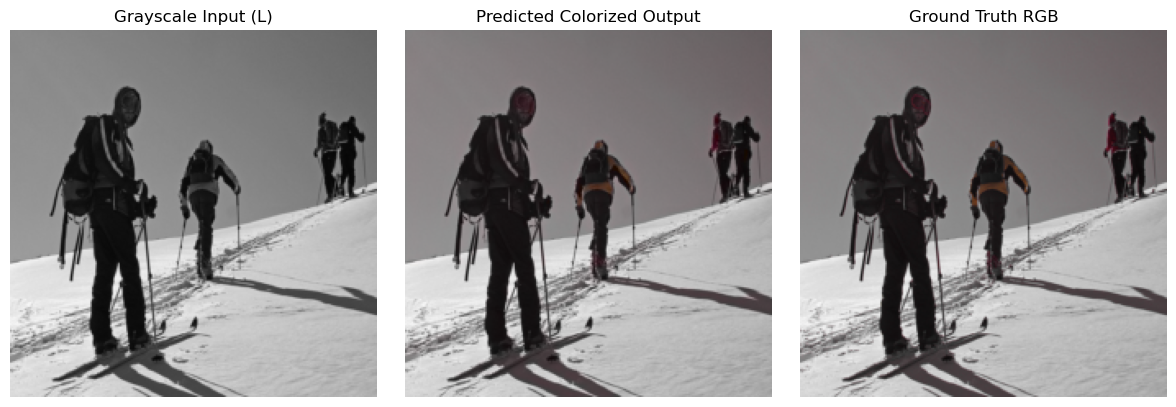

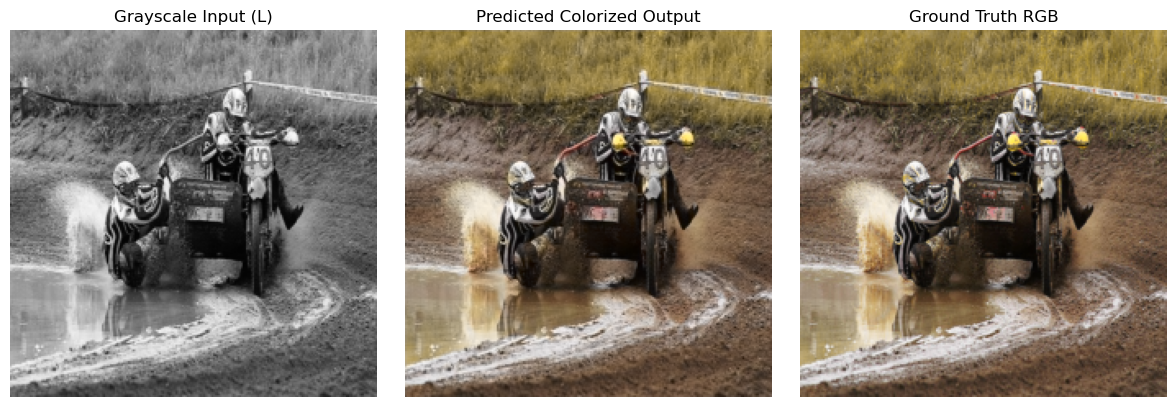

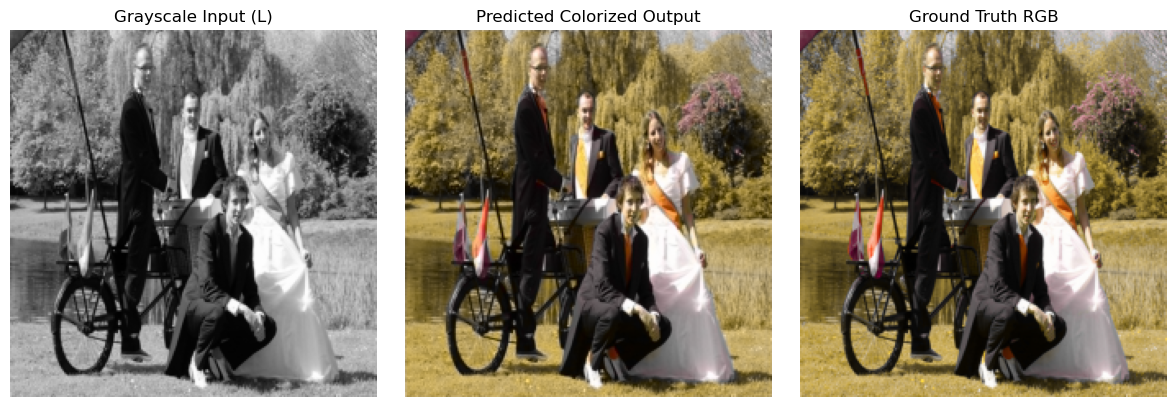

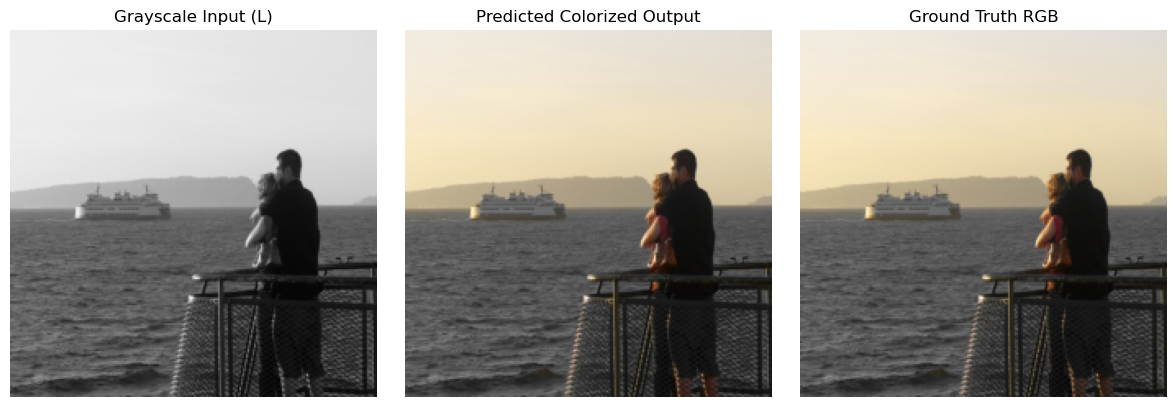

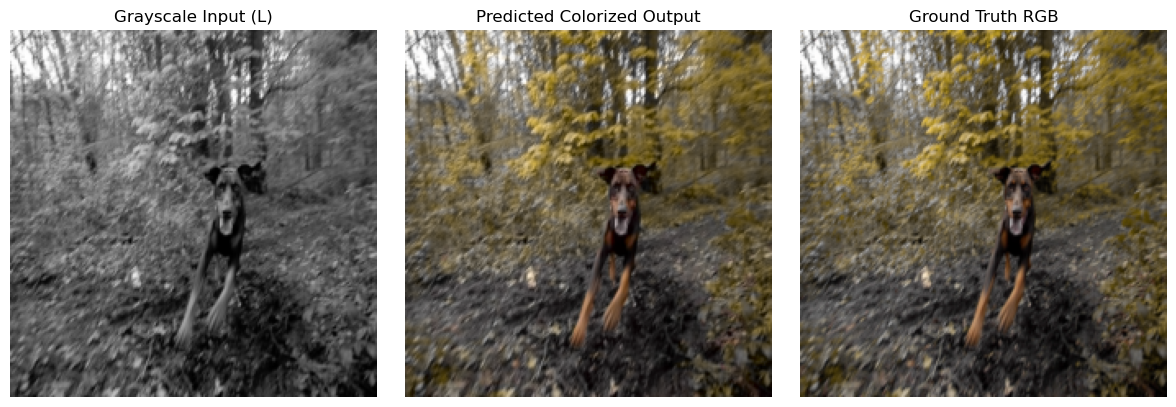

In [11]:
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import numpy as np
import random

# Pick random samples
num_samples = 5
indices = random.sample(range(len(test_dataset)), num_samples)

model.eval()

for idx in indices:
    img_l, img_ab, pixel_values = test_dataset[idx]
    img_l = img_l.unsqueeze(0).to(model.device)         # (1,1,H,W)
    pixel_values = pixel_values.unsqueeze(0).to(model.device)  # (1,3,H,W)

    with torch.no_grad():
        pred_ab = model(pixel_values)

    # Convert tensors to numpy
    pred_ab_np = pred_ab.squeeze(0).cpu().numpy()       # (2, H, W)
    img_l_np = img_l.squeeze(0).squeeze(0).cpu().numpy()  # (H, W)
    img_ab_np = img_ab.numpy()

    # Combine L + AB channels to form LAB image
    pred_lab = np.zeros((img_l_np.shape[0], img_l_np.shape[1], 3))
    pred_lab[:, :, 0] = img_l_np * 100.0                  # De-normalize L
    pred_lab[:, :, 1:] = pred_ab_np.transpose(1, 2, 0) * 128.0  # De-normalize AB

    target_lab = np.zeros((img_l_np.shape[0], img_l_np.shape[1], 3))
    target_lab[:, :, 0] = img_l_np * 100.0
    target_lab[:, :, 1:] = img_ab_np.transpose(1, 2, 0) * 128.0

    # Convert LAB to RGB
    pred_rgb = lab2rgb(pred_lab.clip(0, 255))
    target_rgb = lab2rgb(target_lab.clip(0, 255))

    # Input grayscale image (repeated for 3 channels)
    gray_img = np.stack([img_l_np]*3, axis=2)

    # Show results
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(gray_img)
    axs[0].set_title("Grayscale Input (L)")
    axs[1].imshow(pred_rgb)
    axs[1].set_title("Predicted Colorized Output")
    axs[2].imshow(target_rgb)
    axs[2].set_title("Ground Truth RGB")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [12]:
# STEP 4 (UPDATED): Improved ViTColorizationModel Class with Better Decoder + Loss Weight
#vit_cnn_bn_vggloss_v1

class ViTColorizationModel(LightningModule):
    def __init__(self, model_id="google/vit-base-patch16-224-in21k", dropout_rate=0.5, cache_dir=None, learning_rate=0.0001):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        self.vit = ViTModel.from_pretrained(model_id, cache_dir=cache_dir)

        # UPDATED Decoder with BatchNorm
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(768, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        self.perceptual_loss = PerceptualLoss()

    def forward(self, pixel_values):
        features = self.vit(pixel_values).last_hidden_state
        features = features[:, 1:, :]  # remove CLS token
        batch_size, seq_len, hidden_dim = features.shape
        num_patches = int(seq_len ** 0.5)
        features = features.permute(0, 2, 1).reshape(batch_size, hidden_dim, num_patches, num_patches)
        ab_output = self.decoder(features)
        return ab_output

    def training_step(self, batch, batch_idx):
        img_l, img_ab, pixel_values = batch
        img_l, img_ab, pixel_values = img_l.to(self.device), img_ab.to(self.device), pixel_values.to(self.device)
        pred_ab = self(pixel_values)

        mse_loss = F.mse_loss(pred_ab, img_ab)
        pred_rgb = torch.cat([img_l, pred_ab], dim=1)
        target_rgb = torch.cat([img_l, img_ab], dim=1)
        perceptual_loss = self.perceptual_loss(pred_rgb, target_rgb)

        total_loss = mse_loss + 0.5 * perceptual_loss  # UPDATED LOSS WEIGHT
        self.log("train_loss", total_loss, on_step=True, on_epoch=True, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        img_l, img_ab, pixel_values = batch
        img_l, img_ab, pixel_values = img_l.to(self.device), img_ab.to(self.device), pixel_values.to(self.device)
        pred_ab = self(pixel_values)

        mse_loss = F.mse_loss(pred_ab, img_ab)
        pred_rgb = torch.cat([img_l, pred_ab], dim=1)
        target_rgb = torch.cat([img_l, img_ab], dim=1)
        perceptual_loss = self.perceptual_loss(pred_rgb, target_rgb)

        total_loss = mse_loss + 0.5 * perceptual_loss
        self.log("val_loss", total_loss.cpu(), on_step=True, on_epoch=True, prog_bar=True)
        return total_loss

    def test_step(self, batch, batch_idx):
        img_l, img_ab, pixel_values = batch
        img_l, img_ab, pixel_values = img_l.to(self.device), img_ab.to(self.device), pixel_values.to(self.device)
        pred_ab = self(pixel_values)

        mse_loss = F.mse_loss(pred_ab, img_ab)
        pred_rgb = torch.cat([img_l, pred_ab], dim=1)
        target_rgb = torch.cat([img_l, img_ab], dim=1)
        perceptual_loss = self.perceptual_loss(pred_rgb, target_rgb)

        total_loss = mse_loss + 0.5 * perceptual_loss
        psnr = 10 * torch.log10(1.0 / total_loss)

        self.log("test_loss", total_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("psnr", psnr, on_step=True, on_epoch=True, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)


In [19]:
#vit_cnn_bn_vggloss_v1
# STEP 8: Dataset Setup + Training + Save New Model Version (from scratch)

# New model version name for tracking
model_version = "vit_cnn_bn_vggloss_v1"
CACHE_DIR = os.path.join(args.cache_dir, model_version)
os.makedirs(CACHE_DIR, exist_ok=True)

# Transform for input images
transform = transforms.Compose([
    transforms.Resize((args.image_size, args.image_size)),
    transforms.ToTensor()
])

# Load image file paths from folders
train_files = sorted(glob(os.path.join(args.folder_path, "train", "*.jpg")) + glob(os.path.join(args.folder_path, "train", "*.png")))
val_files = sorted(glob(os.path.join(args.folder_path, "val", "*.jpg")) + glob(os.path.join(args.folder_path, "val", "*.png")))
test_files = sorted(glob(os.path.join(args.folder_path, "test", "*.jpg")) + glob(os.path.join(args.folder_path, "test", "*.png")))

print(f"Train files: {len(train_files)} | Val files: {len(val_files)} | Test files: {len(test_files)}")

# Create Dataset objects
train_dataset = ColorizationDataset(train_files, transform=transform, cache_dir=CACHE_DIR)
val_dataset = ColorizationDataset(val_files, transform=transform, cache_dir=CACHE_DIR)
test_dataset = ColorizationDataset(test_files, transform=transform, cache_dir=CACHE_DIR)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

# Initialize NEW Model (with BatchNorm + Perceptual Loss)
model = ViTColorizationModel(
    dropout_rate=args.dropout_rate,
    cache_dir=CACHE_DIR,
    learning_rate=args.learning_rate
)

# Setup Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(CACHE_DIR, args.checkpoint_dir),
    filename=args.checkpoint_filename,
    monitor="val_loss",
    save_top_k=1,
    mode="min"
)

loss_plot_callback = LossPlotCallback(
    cache_dir=CACHE_DIR,
    loss_log_filename=args.loss_log_filename,
    loss_plot_filename=args.loss_plot_filename,
    plot_figsize=args.plot_figsize,
    plot_dpi=args.plot_dpi
)

text_logger = TextLogger(CACHE_DIR)
loss_logging_callback = LossLoggingCallback(text_logger)

# Setup Trainer
trainer = Trainer(
    max_epochs=args.max_epochs,
    precision=16,
    accelerator="gpu",
    devices=1,
    callbacks=[checkpoint_callback, loss_plot_callback, loss_logging_callback],
    default_root_dir=CACHE_DIR,
    check_val_every_n_epoch=args.validation_interval,
    log_every_n_steps=10
)

# Train model
trainer.fit(model, train_loader, val_loader)

# Test model on best checkpoint
best_ckpt_path = checkpoint_callback.best_model_path
print(f"✅ Best checkpoint saved at: {best_ckpt_path}")

# Reload best checkpoint and test
model = ViTColorizationModel.load_from_checkpoint(
    checkpoint_path=best_ckpt_path,
    cache_dir=CACHE_DIR,
    learning_rate=args.learning_rate,
    dropout_rate=args.dropout_rate
)

trainer.test(model, test_loader)


Train files: 5663 | Val files: 1213 | Test files: 1215


/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/lightning/fabric/connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/a.kanamarlapudi001/projects/ml_cv_projects/Image-Colorization/cache/vit_cnn_bn_vggloss_v1/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBL

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |                                                                                     | 0/? [00:00…

/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |                                                                                     | 0/? [00:00…

/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |                                                                                     | 0/? [00:00…

/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |                                                                                     | 0/? [00:00…

/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |                                                                                     | 0/? [00:00…

/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |                                                                                     | 0/? [00:00…

/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |                                                                                     | 0/? [00:00…

/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=15` reached.


✅ Best checkpoint saved at: /home/a.kanamarlapudi001/projects/ml_cv_projects/Image-Colorization/cache/vit_cnn_bn_vggloss_v1/checkpoints/best_vit_colorization-v1.ckpt


/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/py ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/a.kanamarlapudi001/miniconda3/envs/mlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       psnr_epoch            10.87582015991211
     test_loss_epoch        0.08364962786436081
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.08364962786436081, 'psnr_epoch': 10.87582015991211}]

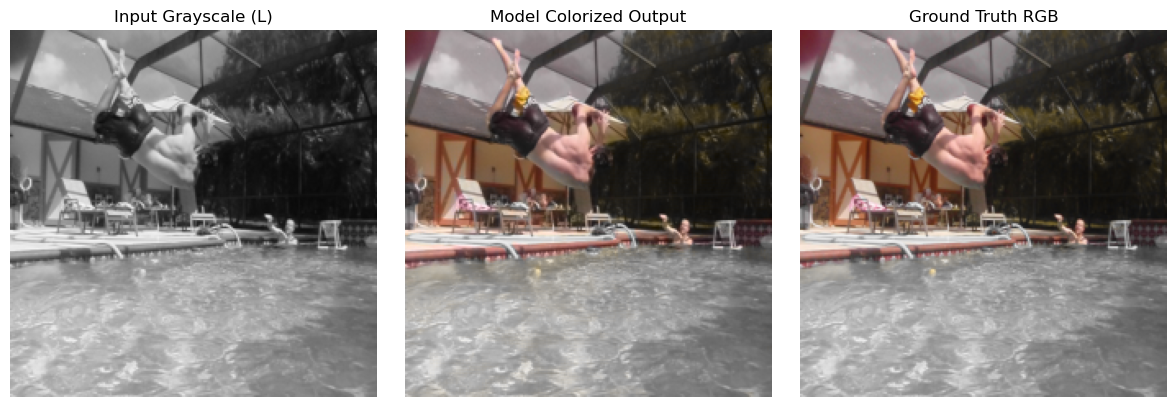

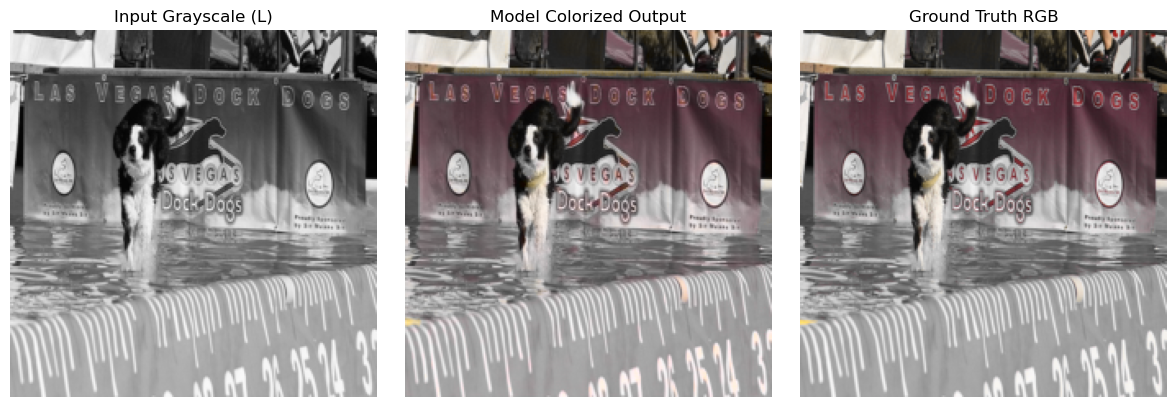

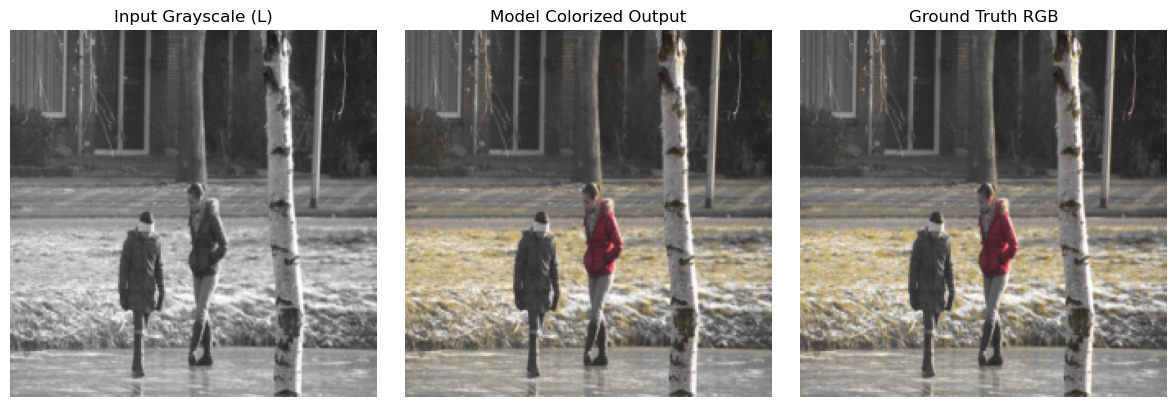

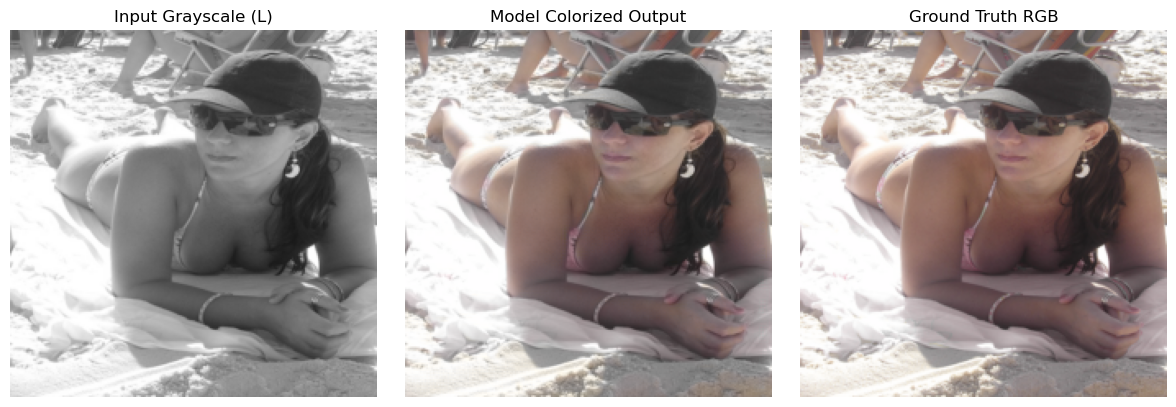

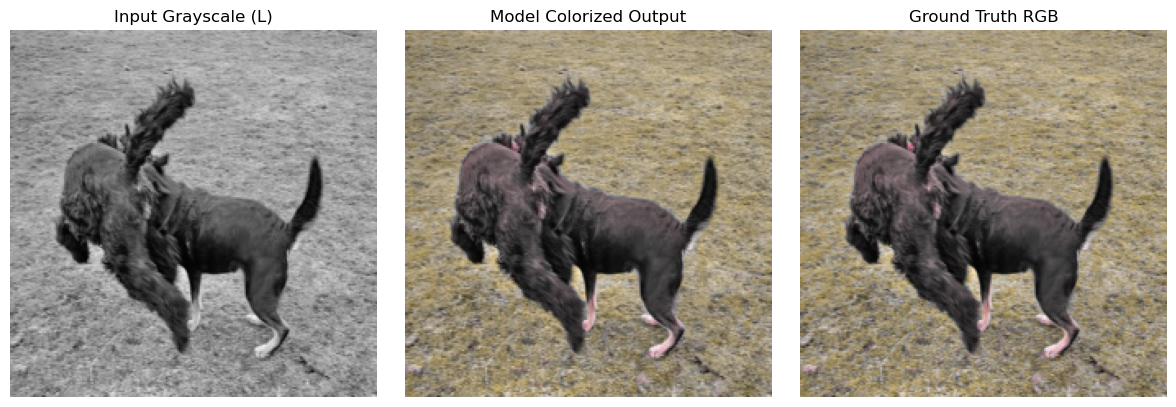

In [21]:
# STEP 9: Visualize Model Predictions (Grayscale vs Colorized vs Ground Truth)

from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import numpy as np
import random

# How many samples to show
num_samples = 5
indices = random.sample(range(len(test_dataset)), num_samples)

model.eval()

for idx in indices:
    img_l, img_ab, pixel_values = test_dataset[idx]
    img_l = img_l.unsqueeze(0).to(model.device)
    pixel_values = pixel_values.unsqueeze(0).to(model.device)

    # Predict AB channels
    with torch.no_grad():
        pred_ab = model(pixel_values)

    # Convert tensors to numpy
    pred_ab_np = pred_ab.squeeze(0).cpu().numpy()       # (2, H, W)
    img_l_np = img_l.squeeze(0).squeeze(0).cpu().numpy()  # (H, W)
    img_ab_np = img_ab.numpy()  # Ground truth

    # Convert L+AB → LAB → RGB
    pred_lab = np.zeros((img_l_np.shape[0], img_l_np.shape[1], 3))
    pred_lab[:, :, 0] = img_l_np * 100
    pred_lab[:, :, 1:] = pred_ab_np.transpose(1, 2, 0) * 128

    target_lab = np.zeros((img_l_np.shape[0], img_l_np.shape[1], 3))
    target_lab[:, :, 0] = img_l_np * 100
    target_lab[:, :, 1:] = img_ab_np.transpose(1, 2, 0) * 128

    # Convert to RGB
    pred_rgb = lab2rgb(pred_lab.clip(0, 255))
    target_rgb = lab2rgb(target_lab.clip(0, 255))
    grayscale_rgb = np.stack([img_l_np]*3, axis=2)

    # Display images
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(grayscale_rgb)
    axs[0].set_title("Input Grayscale (L)")

    axs[1].imshow(pred_rgb)
    axs[1].set_title("Model Colorized Output")

    axs[2].imshow(target_rgb)
    axs[2].set_title("Ground Truth RGB")

    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


## ✅ Summary of Updates and Enhancements

This notebook originally started with a basic ViT + CNN image colorization model. Below are the key updates and improvements made throughout the process:

# Architectural Enhancements:
- Added **VGG19-based Perceptual Loss** to improve visual realism by comparing feature maps instead of just pixel-level accuracy.
- Retained **Vision Transformer (ViT)** as the encoder to extract global features from grayscale images.
- Used a **CNN Decoder** with ConvTranspose2d layers to reconstruct the AB channels of the LAB color space.
- Integrated **Dropout layers (configurable)** in decoder to prevent overfitting.
- Trained model using **Mixed Precision (16-bit AMP)** on GPU for faster performance.

# Training & Logging Improvements:
- Added **LossPlotCallback** to generate train vs validation loss curves.
- Added **TextLogger** to save training/validation/test metrics in a readable `.txt` log file.
- Introduced **LossLoggingCallback** to record per-epoch metrics in logs automatically.
- Used **ModelCheckpoint callback** to save the best model based on validation loss.
- Improved dataset handling with **automatic 70%/15%/15% split** for train, val, and test sets.

#  Dataset Structure:
- Dataset is divided into three folders: `train/`, `val/`, and `test/`.
- The model input is the **L-channel (grayscale)**, and the target is the **AB channels**.

# Training Hyperparameters Used:
- **Batch Size:** 4
- **Image Size:** 224 × 224
- **Learning Rate:** 0.0001
- **Epochs:** Initially 5 → Later extended to 15 → Final version trained for 30 epochs
- **Dropout Rate:** 0.1

# Evaluation:
- Colorization results are visualized by comparing:
  - Input Grayscale Image
  - Model’s Predicted Colorized Image
  - Ground Truth Color Image
- VGG19 perceptual loss helped improve texture, edge sharpness, and color realism.

---
This final version of the model can be referred to as **"ViT + CNN + VGG19 Perceptual Loss Model"**

